## Computational Challenge 6

Group \#4

Students: Zhao Zheng, Rashedur Rahman, Thuyen Dang, and Alan Akil

Course: Math 6397 - Stochastic Processes in Biology

Professors: Dr. Josić & Dr. Stewart

$\textbf{Challenge:}$

In this challenge you will examine 3 different version of the integrate–and–fire model: the
leaky (QIF), the quadratic, and the exponential integrate-and-fire model. The fourth group will
implement an adaptive version of the integrate and fire model.
To start, you will need a function that generates an inhomogeneous Poisson spike train. You
can do this by using the method that we described in an earlier computational challenge, or simply
using discrete increments. Use a resolution of at least 0.5ms

The leaky integrate and fire model with an adaptive current has the form

$$
\tau_m u' = -u + RI(t) -Rv
$$
$$
\tau_v v' = au - v + b\tau_v \sum_{t^f}\delta (t-t^f)
$$

The sum $\sum_{t^f}\delta (t-t^f)$ goes over all the spike times of the model. 
Set $\tau_v=100$ms, $\tau_m=10$ms, and $R=500$M$\Omega$. Set the threshold at 20mV.

You may find Chapter 6 in the book by Gerstner, et al. helpful for this problem.

(a) Set $b = 5$pA, and vary $a$ from negative to positive values. Plot some of the firing patterns
that you observe as you increase the input current $I$ from zero to 100pA.

(b) Assume the input is described by a Poisson process. Assume that the weight of each
synapse is $w=1$, with current measured in pA. Assume that each input spike results in
an instant depolarization. As a result model the effect of each spike as an instantaneous increase in the membrane potential by $\Delta u=0.5$mV. Take two different output patterns
you observed in the previous part, and see if they are changed if the input is described
by a Poisson process, with the same average that you used in part (a).

(c) Assume that the input is composed of two independent Poisson spike trains. One
corresponds to inputs with synapse weights $w=1$ (excitatory inputs), and the other with
$w=-1$ (inhibitory inputs). Denote the two input rates by $\nu_E$ and $\nu_I$. Start with a
$\nu_E$ that gave an output spike rate of 20Hz in the previous part with an adaptive
output. Gradually increase the $\nu_I$, and plot the output firing rate, and the coefficient
of variation for the inter-spike interval (time between spikes). Make sure to plot some
output spike trains. You can represent them as raster plots. Discuss with group 1 the
effect of the adaptive current on the output.

In [5]:
# Import packages needed.
import numpy as np
import random
from scipy.special import gamma, factorial
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import tqdm
from numba import jit
from numba import njit, prange
import time
from scipy.integrate import solve_ivp

## Define the function for simulating Case 1 and 2

In [500]:

# Start the simulation.
# start_time = time.time()
# elapsed_time = time.time()-start_time
# print(elapsed_time/60, 'minutes')
def EulerMethod_const_input(I,u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time):
    nspike = 0
    maxns=round(100000*T); # max numbers of spikes
    s = np.zeros((1,maxns))
    u = np.zeros_like(Total_time)
    u_saved = np.zeros_like(Total_time)
    v = np.zeros_like(Total_time)
    alpha_spikes = 0
    
    for i in range(len(Total_time)-1): 
        # Euler update to u - mem pot
        u[i+1] = u[i] + (dt/tau_m)*(-u[i] + R*I[i] - R*v[i] )
        
        # Euler update to v - adap var
        v[i+1] = v[i] + (dt/tau_v)*(a*u[i] - v[i] + b*tau_v*alpha_spikes)

        # If there are spikes
        if(u[i+1]>=u_thres):
            s[0,nspike]=Total_time[i]       

            # Update cumulative number of spikes
            nspike+=1
        
            # This makes plots of u(t) look better.
            # All action potentials reach u_thres exactly. 
            u_saved[i+1]=u_thres

            # Reset mem pot.
            u[i+1]=u_rest
            
            alpha_spikes = 1
        else:
            alpha_spikes = 0
            u_saved[i+1]=u[i+1]

    s=s[0,0:nspike] # Get rid of padding in s
    
    return u, u_saved, v, s

In [503]:
# Total_time  for sim
T = 200 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 #sec
R = 500 * 10**6 # Ohms

# Adaptation parameters
w = 1 / 10**(-3)
a = 1.000 * 10**(-9) # Amps
b = 600000 * 10**(-12) # Amps

# Input 
I = np.zeros_like(Total_time)
start_stim = T/10
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 100 * 10**(-12)

u, u_saved, v, s = EulerMethod_const_input(I,u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time)


# Plot a sample trajectory of membrane potential

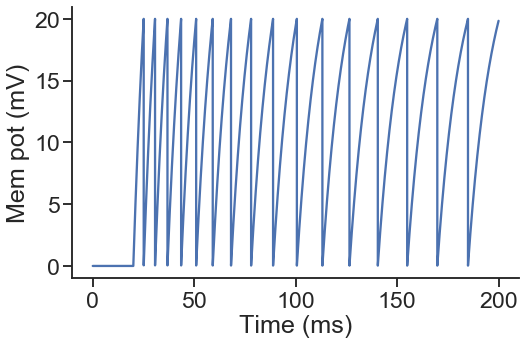

In [504]:
# Create figure and plot 
## Plot results
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth":2.3})

plt.plot(Total_time*10**3 ,u_saved*10**3)

plt.xlabel('Time (ms)')
plt.ylabel('Mem pot (mV)')

sns.despine()
plt.show()

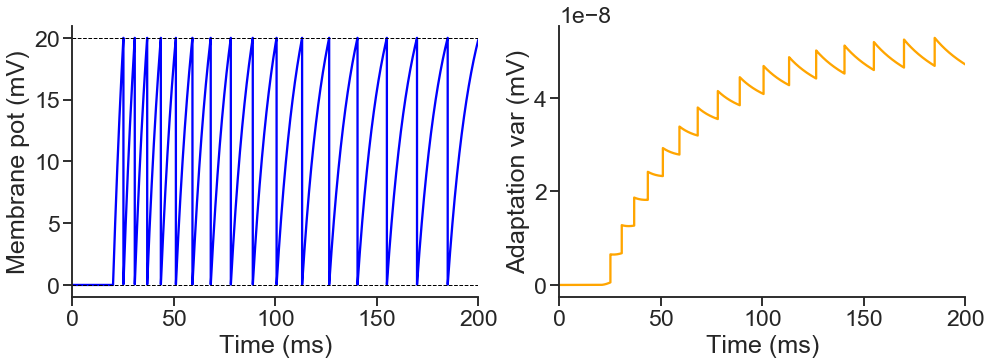

In [505]:
# print('Case 1, High k_yz')
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].plot(Total_time*10**3 ,u_saved*10**3,color='blue')
# axs[0].set_title('OFF to ON')
axs[0].axhline(y=u_thres*10**3,color='black', linestyle='--',
              linewidth=1)
axs[0].axhline(y=u_rest*10**3,color='black', linestyle='--',
              linewidth=1)
axs[0].set(xlabel='Time (ms)', ylabel='Membrane pot (mV)',
          xlim = (0,T*10**3))

axs[1].plot(Total_time*10**3 ,v*10**3,color='orange')
axs[1].set(xlabel='Time (ms)', ylabel='Adaptation var (mV)',
          xlim = (0,T*10**3))


# for ax in axs.flat:
#     ax.set(xlabel='Response time', ylabel='Count',
#           xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

sns.despine()
    
plt.show()

# Set $b = 5$pA, and vary $a$ from negative to positive values. Plot some of the firing patterns that you observe as you increase the input current $I$ from zero to 100pA.

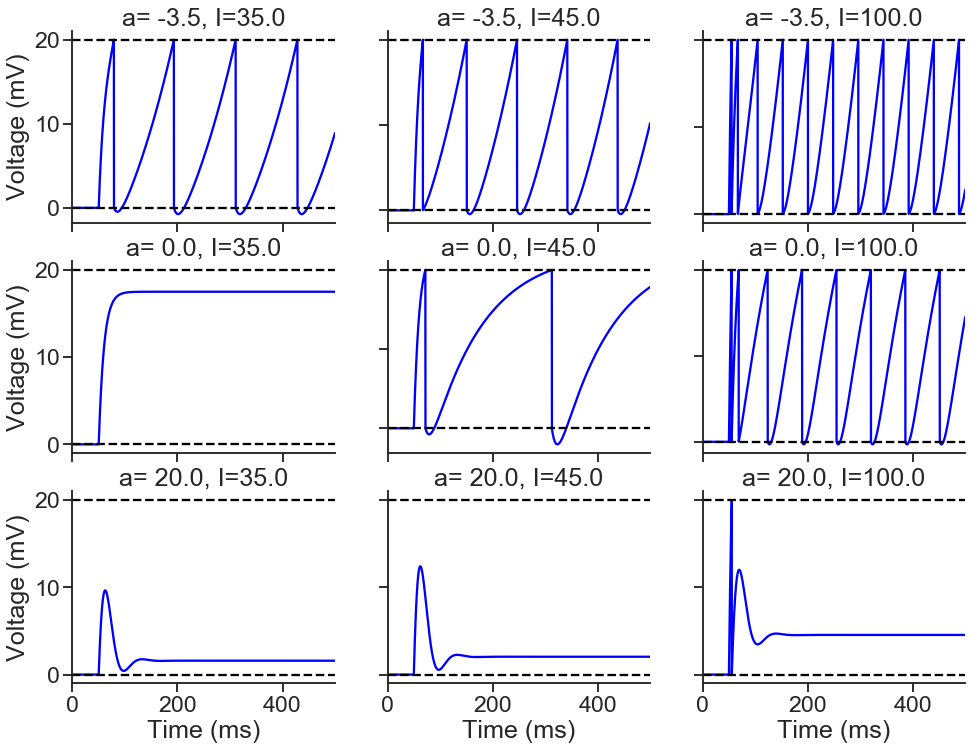

In [506]:
# Total_time  for sim
T = 500 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 #sec
R = 500 * 10**6 # Ohms


## Sim 1
# Adaptation parameters
w = 1 / 10**(-3)
a = -10 * 10**(-9) # S
b = 5000000 * 10**(-12) # Amps
# Input 
I = np.zeros_like(Total_time)
start_stim = T/10
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 100 * 10**(-12)


a_vec = np.array([-3.5, 0, 20]) * 10**(-9)

I_strength = np.array([35,45,100]) * 10**(-12)

# Create figure and plot 
fig, axs = plt.subplots(3, 3, figsize=(16,12))

for i in range(len(a_vec)):
    for j in range(len(I_strength)):
        # Input 
        I = np.zeros_like(Total_time)
        start_stim = T/10
        end_stim = T
        I[int(start_stim//dt):int(end_stim//dt)] = I_strength[j] 
        
        u, u_saved, v, s = EulerMethod_const_input(I,u_rest,u_thres,dt,tau_m,tau_v,R,w,a_vec[i]
                                                       ,b,T,Total_time)

        axs[i,j].plot(Total_time*10**3 ,u_saved*10**3,color='blue')
        axs[i,j].axhline(y=u_rest*10**3,color='black',linestyle='--')
        axs[i,j].axhline(y=u_thres*10**3,color='black',linestyle='--')
        axs[i,j].set( title='a= '+str(round(a_vec[i]*10**9,1))+', I='+str(I_strength[j]*10**12))

for ax in axs.flat:
    ax.set(ylabel='Voltage (mV)', xlabel='Time (ms)',
          xlim=(0,T*10**3) )
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

sns.despine()
    
plt.show()

 (b) Assume the input is described by a Poisson process. Assume that the weight of each synapse is $w=1$, with current measured in pA. Assume that each input spike results in an instant depolarization. As a result model the effect of each spike as an instantaneous increase in the membrane potential by $\Delta u=0.5$mV. Take two different output patterns you observed in the previous part, and see if they are changed if the input is described by a Poisson process, with the same average that you used in part (a).

In [507]:
# Poisson spike train generation.
def inhomo_PoissonSpikeTrain(dt,T,rx,Total_time):
    rand_unis = np.random.uniform(0,1,(1,len(Total_time)))
    num_spikes = 0
    spikes_x = np.zeros_like(Total_time)
    spike_time_x = np.zeros((int(T*10**9)))
    for i in range(len(Total_time)):
        prob = rx[i] * dt # rx is time-dependent rate.
        if (prob > rand_unis[0,i]):
            spike_time_x[num_spikes] = Total_time[i]
            spikes_x[i] = 1
            num_spikes += 1
        else:
            spikes_x[i] = 0
    spike_time_x = spike_time_x[0:num_spikes]
    return spike_time_x, spikes_x

In [508]:
def EulerMethod_poisson_input(spike_time_x,spikes_x,u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time):
    nspike = 0
    maxns=round(T*10**9); # max numbers of spikes
    s = np.zeros((1,maxns))
    u = np.zeros_like(Total_time)
    u_saved = np.zeros_like(Total_time)
    v = np.zeros_like(Total_time)
    alpha_spikes = 0
    
    for i in range(len(Total_time)-1): 

        # Euler update to u - mem pot
        u[i+1] = u[i] + (dt/tau_m)*(-u[i] - R*v[i] + w * R * spikes_x[i] )
                
        # Euler update to v - adap var
        v[i+1] = v[i] + (dt/tau_v)*(a*u[i] - v[i] + b*tau_v*alpha_spikes)

        # If there are spikes
        if(u[i+1]>=u_thres):
            s[0,nspike]=Total_time[i]       

            # Update cumulative number of spikes
            nspike+=1
        
            # This makes plots of u(t) look better.
            # All action potentials reach u_thres exactly. 
            u_saved[i+1]=u_thres

            # Reset mem pot.
            u[i+1]=u_rest
            
            alpha_spikes = 1
        else:
            alpha_spikes = 0
            u_saved[i+1]=u[i+1]

    s=s[0,0:nspike] # Get rid of padding in s
    
    return u, u_saved, v, s

In [629]:
# Total_time  for sim
T = 500 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 # sec
R = 500 * 10**6 # Ohms

# Adaptation parameters
Num_synapses = 10**4
w = Num_synapses * 1 / 10**12 # Amps
a = 1 * 10**(-9) # S
b = 1000 * 10**(-12) *10**3 # Amps


# Input 
I = np.zeros_like(Total_time)
start_stim = 0
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 0

# Inhomogeneous rate for Poisson spike trains
rx = 200 * (np.sin(Total_time/100) + 2) # Hz

np.random.seed(10)

spike_time_x, spikes_x = inhomo_PoissonSpikeTrain(dt,T,rx,Total_time)

u, u_saved, v, s = EulerMethod_poisson_input(spike_time_x,spikes_x,
                                             u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time)


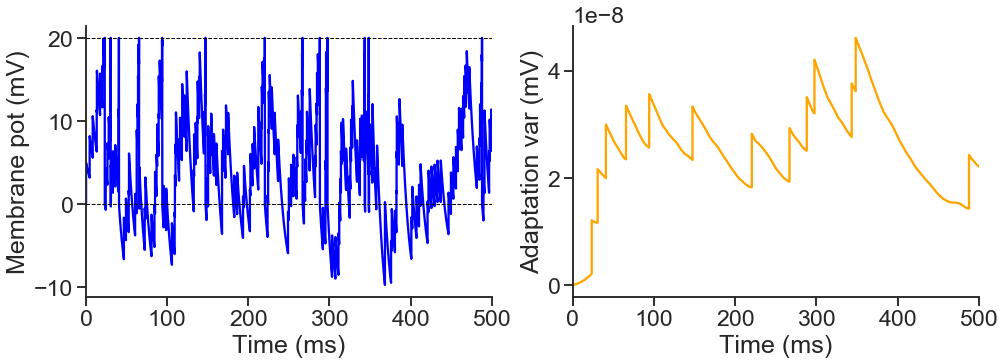

Firing rate= 26.0 Hz


In [630]:
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].plot(Total_time*10**3 ,u_saved*10**3,color='blue')
# axs[0].set_title('OFF to ON')
axs[0].axhline(y=u_thres*10**3,color='black', linestyle='--',
              linewidth=1)
axs[0].axhline(y=u_rest*10**3,color='black', linestyle='--',
              linewidth=1)
axs[0].set(xlabel='Time (ms)', ylabel='Membrane pot (mV)',
          xlim = (0,T*10**3))

axs[1].plot(Total_time*10**3 ,v*10**3,color='orange')
axs[1].set(xlabel='Time (ms)', ylabel='Adaptation var (mV)',
          xlim = (0,T*10**3))


# for ax in axs.flat:
#     ax.set(xlabel='Response time', ylabel='Count',
#           xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

sns.despine()

plt.show()

firing_rate = len(s)/T

print('Firing rate=',firing_rate,'Hz')

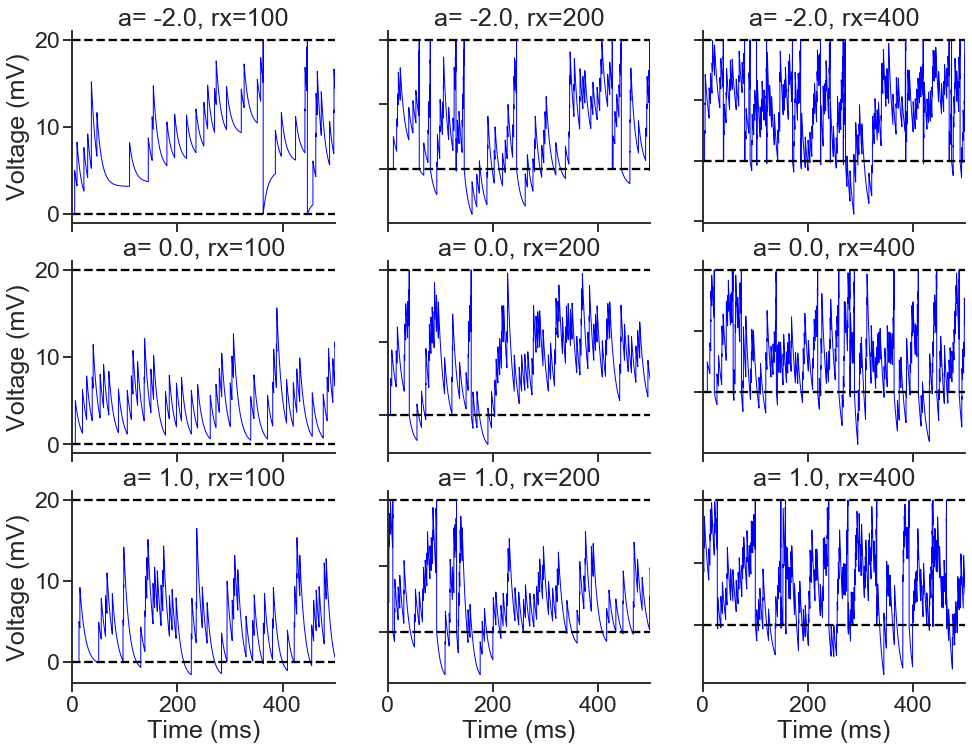

In [692]:
# Total_time  for sim
T = 500 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 #sec
R = 500 * 10**6 # Ohms


## Sim 1
# Adaptation parameters
Num_synapses = 10**4
w = Num_synapses * 1 / 10**12 # Amps
a = 1 * 10**(-9) # S
b = 1000 * 10**(-12) *10**3 # Amps 


##
a_vec = np.array([-2, 0, 1]) * 10**(-9)

rx_strength = np.array([100,200,400]) # Hz


# Input 
I = np.zeros_like(Total_time)
start_stim = 0
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 0


np.random.seed(101)


# Create figure and plot 
fig, axs = plt.subplots(3, 3, figsize=(16,12))

for i in range(len(a_vec)):
    for j in range(len(rx_strength)):
 
        # Inhomogeneous rate for Poisson spike trains
#         rx =  rx_strength[j] * (np.sin(Total_time) + 2) # Hz
        rx =  rx_strength[j] * (np.ones_like(Total_time)) # Hz
        spike_time_x, spikes_x = inhomo_PoissonSpikeTrain(dt,T,rx,Total_time)
    

    
        u, u_saved, v, s = EulerMethod_poisson_input(spike_time_x,spikes_x,u_rest,
                                                     u_thres,dt,tau_m,tau_v,R,w,a_vec[i]
                                                       ,b,T,Total_time)

        axs[i,j].plot(Total_time*10**3 ,u_saved*10**3,color='blue',linewidth=1)
        axs[i,j].axhline(y=u_rest*10**3,color='black',linestyle='--')
        axs[i,j].axhline(y=u_thres*10**3,color='black',linestyle='--')
        axs[i,j].set( title='a= '+str(round(a_vec[i]*10**9,1))+', rx='+str(rx_strength[j]))

for ax in axs.flat:
    ax.set(ylabel='Voltage (mV)', xlabel='Time (ms)',
          xlim=(0,T*10**3) )
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

sns.despine()
    
plt.show()

(c) Assume that the input is composed of two independent Poisson spike trains. One
corresponds to inputs with synapse weights $w=1$ (excitatory inputs), and the other with
$w=-1$ (inhibitory inputs). Denote the two input rates by $\nu_E$ and $\nu_I$. Start with a
$\nu_E$ that gave an output spike rate of 20Hz in the previous part with an adaptive
output. Gradually increase the $\nu_I$, and plot the output firing rate, and the coefficient
of variation for the inter-spike interval (time between spikes). Make sure to plot some
output spike trains. You can represent them as raster plots. Discuss with group 1 the
effect of the adaptive current on the output.

In [638]:
def EulerMethod_poisson_input_balanced(spikes_x1,spikes_x2,u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time):
    nspike = 0
    maxns=round(T*10**9); # max numbers of spikes
    s = np.zeros((1,maxns))
    u = np.zeros_like(Total_time)
    u_saved = np.zeros_like(Total_time)
    v = np.zeros_like(Total_time)
    alpha_spikes = 0
    
    for i in range(len(Total_time)-1): 

        # Euler update to u - mem pot
        u[i+1] = u[i] + (dt/tau_m)*(-u[i] - R*v[i] + w * R * spikes_x1[i] -  w * R * spikes_x2[i] )
                   
        # Euler update to v - adap var
        v[i+1] = v[i] + (dt/tau_v)*(a*u[i] - v[i] + b*tau_v*alpha_spikes)

        # If there are spikes
        if(u[i+1]>=u_thres):
            s[0,nspike]=Total_time[i]       

            # Update cumulative number of spikes
            nspike+=1
        
            # This makes plots of u(t) look better.
            # All action potentials reach u_thres exactly. 
            u_saved[i+1]=u_thres

            # Reset mem pot.
            u[i+1]=u_rest
            
            alpha_spikes = 1
        else:
            alpha_spikes = 0
            u_saved[i+1]=u[i+1]

    s=s[0,0:nspike] # Get rid of padding in s
    
    return u, u_saved, v, s

In [641]:
# Total_time  for sim
T = 500 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 # sec
R = 500 * 10**6 # Ohms

# Adaptation parameters
Num_synapses = 10**4
w = Num_synapses * 1 / 10**12 # Amps
a = 1 * 10**(-9) # S
b = 1000 * 10**(-12) *10**3 # Amps 


# Input 
I = np.zeros_like(Total_time)
start_stim = 0
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 0

# Inhomogeneous rate for Poisson spike trains
rx_e =  500 * (np.ones_like(Total_time)) # Hz

# Inhomogeneous rate for Poisson spike trains
rx_i =  500 * (np.ones_like(Total_time)) # Hz


np.random.seed(10)

# Exc input
spike_time_x_e, spikes_x_e = inhomo_PoissonSpikeTrain(dt,T,rx_e,Total_time)
#Inh input
spike_time_x_i, spikes_x_i = inhomo_PoissonSpikeTrain(dt,T,rx_i,Total_time)

u, u_saved, v, s = EulerMethod_poisson_input_balanced(spikes_x_e,spikes_x_i,
                                             u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time)


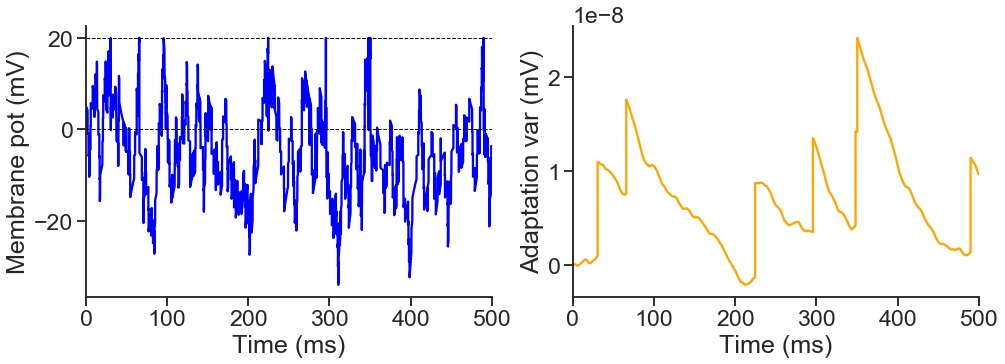

Firing rate= 14.0 Hz


In [643]:
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].plot(Total_time*10**3 ,u_saved*10**3,color='blue')
# axs[0].set_title('OFF to ON')
axs[0].axhline(y=u_thres*10**3,color='black', linestyle='--',
              linewidth=1)
axs[0].axhline(y=u_rest*10**3,color='black', linestyle='--',
              linewidth=1)
axs[0].set(xlabel='Time (ms)', ylabel='Membrane pot (mV)',
          xlim = (0,T*10**3))

axs[1].plot(Total_time*10**3 ,v*10**3,color='orange')
axs[1].set(xlabel='Time (ms)', ylabel='Adaptation var (mV)',
          xlim = (0,T*10**3))


# for ax in axs.flat:
#     ax.set(xlabel='Response time', ylabel='Count',
#           xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

sns.despine()

plt.show()

firing_rate = len(s)/T

print('Firing rate=',firing_rate,'Hz')

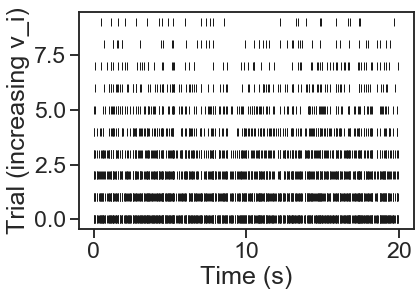

In [681]:
# Total_time  for sim
T = 20000 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 #sec
R = 500 * 10**6 # Ohms


## Sim 1
# Adaptation parameters
Num_synapses = 10**4
w = Num_synapses * 1 / 10**12 # Amps
a = 1 * 10**(-9) # S
b = 1000 * 10**(-12) *10**3 # Amps 


##
rx_i_strength = np.linspace(0,1000,10) # Hz


# Input 
I = np.zeros_like(Total_time)
start_stim = 0
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 0


np.random.seed(101)


# Inhomogeneous rate for Poisson spike trains
rx_e =  500 * (np.ones_like(Total_time)) # Hz
# Exc input
spike_time_x_e, spikes_x_e = inhomo_PoissonSpikeTrain(dt,T,rx_e,Total_time)


# Create figure and plot 
# fig, axs = plt.subplots(3, 3, figsize=(16,12))

firing_rate = np.zeros((len(rx_i_strength),1))
CV = np.zeros((len(rx_i_strength),1))


for j in range(len(rx_i_strength)):

    # Inhomogeneous rate for Poisson spike trains
    rx_i =  rx_i_strength[j] * (np.ones_like(Total_time)) # Hz

    #Inh input
    spike_time_x_i, spikes_x_i = inhomo_PoissonSpikeTrain(dt,T,rx_i,Total_time)

    u, u_saved, v, s = EulerMethod_poisson_input_balanced(spikes_x_e,spikes_x_i,
                                                 u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time)

    firing_rate[j] = len(s)/T
    
    plt.plot( s,j * np.ones_like(s), 'k',marker='|',markersize=8,linestyle='')
    
    
    ISIs = np.diff(s)
    
    CV[j] = np.std(ISIs) / np.mean(ISIs)
    
plt.xlabel('Time (s)')
plt.ylabel('Trial (increasing v_i)')
plt.show()

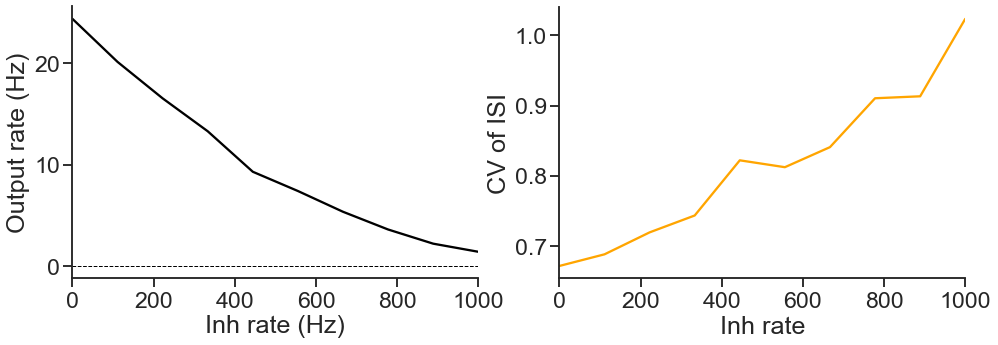

In [682]:
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].plot(rx_i_strength ,firing_rate,color='black')
axs[0].axhline(y=0,color='black',linestyle='--',linewidth=1)

# axs[0].set_title('OFF to ON')
# axs[0].axhline(y=u_thres*10**3,color='black', linestyle='--',
#               linewidth=1)
# axs[0].axhline(y=u_rest*10**3,color='black', linestyle='--',
#               linewidth=1)
axs[0].set(xlabel='Inh rate (Hz)', ylabel='Output rate (Hz)',
          xlim = (0,np.max(rx_i_strength)))

axs[1].plot(rx_i_strength ,CV,color='orange')
axs[1].set(xlabel='Inh rate', ylabel='CV of ISI',
          xlim = (0,np.max(rx_i_strength)))


# for ax in axs.flat:
#     ax.set(xlabel='Response time', ylabel='Count',
#           xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

sns.despine()

plt.show()


## Without adaptation

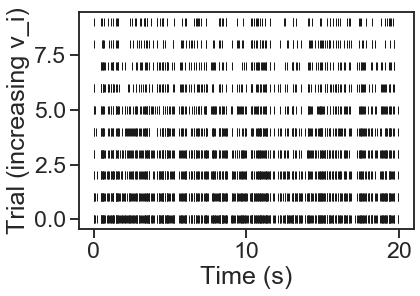

In [689]:
# Total_time  for sim
T = 20000 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 #sec
R = 500 * 10**6 # Ohms


## Sim 1
# Adaptation parameters
Num_synapses = 10**4
w = Num_synapses * 1 / 10**12 # Amps
a = 0#1 * 10**(-9) # S
b = 0#1000 * 10**(-12) *10**3 # Amps 


##
rx_i_strength = np.linspace(0,200,10) # Hz


# Input 
I = np.zeros_like(Total_time)
start_stim = 0
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 0


np.random.seed(101)


# Inhomogeneous rate for Poisson spike trains
rx_e =  250 * (np.ones_like(Total_time)) # Hz
# Exc input
spike_time_x_e, spikes_x_e = inhomo_PoissonSpikeTrain(dt,T,rx_e,Total_time)


# Create figure and plot 
# fig, axs = plt.subplots(3, 3, figsize=(16,12))

firing_rate = np.zeros((len(rx_i_strength),1))
CV = np.zeros((len(rx_i_strength),1))


for j in range(len(rx_i_strength)):

    # Inhomogeneous rate for Poisson spike trains
    rx_i =  rx_i_strength[j] * (np.ones_like(Total_time)) # Hz

    #Inh input
    spike_time_x_i, spikes_x_i = inhomo_PoissonSpikeTrain(dt,T,rx_i,Total_time)

    u, u_saved, v, s = EulerMethod_poisson_input_balanced(spikes_x_e,spikes_x_i,
                                                 u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time)

    firing_rate[j] = len(s)/T
    
    plt.plot( s,j * np.ones_like(s), 'k',marker='|',markersize=8,linestyle='')
    
    
    ISIs = np.diff(s)
    
    CV[j] = np.std(ISIs) / np.mean(ISIs)
    
plt.xlabel('Time (s)')
plt.ylabel('Trial (increasing v_i)')
plt.show()

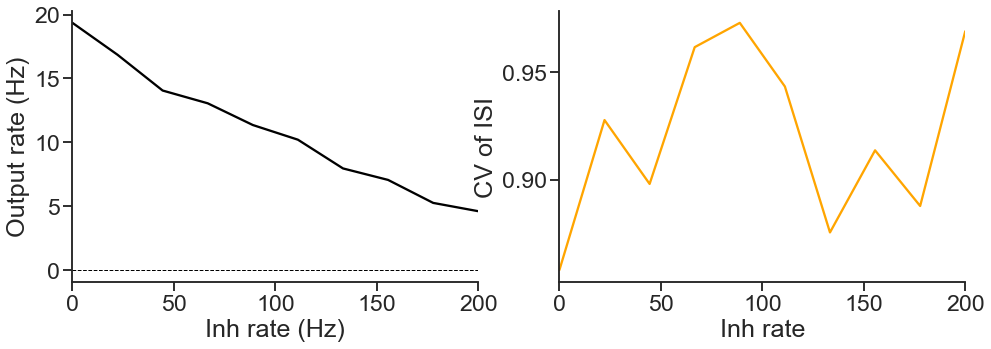

In [690]:
# Create figure and plot 
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].plot(rx_i_strength ,firing_rate,color='black')
axs[0].axhline(y=0,color='black',linestyle='--',linewidth=1)

# axs[0].set_title('OFF to ON')
# axs[0].axhline(y=u_thres*10**3,color='black', linestyle='--',
#               linewidth=1)
# axs[0].axhline(y=u_rest*10**3,color='black', linestyle='--',
#               linewidth=1)
axs[0].set(xlabel='Inh rate (Hz)', ylabel='Output rate (Hz)',
          xlim = (0,np.max(rx_i_strength)))

axs[1].plot(rx_i_strength ,CV,color='orange')
axs[1].set(xlabel='Inh rate', ylabel='CV of ISI',
          xlim = (0,np.max(rx_i_strength)))


# for ax in axs.flat:
#     ax.set(xlabel='Response time', ylabel='Count',
#           xlim=(0,700))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

sns.despine()

plt.show()
